In [58]:
# Import packages

import numpy as np
import pandas as pd
from datetime import *
import calendar
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoLars
from sklearn.svm import SVR
from sklearn.decomposition import PCA
import seaborn
import matplotlib.pyplot as plt
import pickle
import os

# Create constants for dirs
training_dir = 'city_training/'
test_dir = 'city_testing/'

# Create constants for filenames
city_attrib_file = 'city_attributes.csv'
humidity_file = 'humidity.csv'
pressure_file = 'pressure.csv'
temperature_file = 'temperature.csv'
weather_description_file = 'converted.csv'
wind_direction_file = 'wind_direction.csv'
wind_speed_file = 'wind_speed.csv'

models_folder = 'model_pickles/'

training_date_range = ('2013-10-2', '2016-12-31')
test_date_range = ('2017-1-1', '2017-11-30')
# List of all independent variable files we are pulling data from
attrib_files = [humidity_file, pressure_file, temperature_file, weather_description_file, wind_direction_file, wind_speed_file]
# List of all independent variables (not files)
attribs = []
for attrib_file in attrib_files:
    attribs.append(attrib_file[:-4])


# Create lists of 12 cities
cities = list(pd.read_csv(humidity_file, sep=',').columns.values)
cities.remove('datetime')

devin_cities = cities[:12]
ethan_cities = cities[12:24]
phil_cities = cities[24:]


In [21]:
attrib_dfs = []
for file in attrib_files:
    attrib_dfs.append(pd.read_csv(file, sep=','))

In [22]:
# Read in test or train files for the given city
def get_df_train_file(city):
    return pd.read_csv(training_dir + city + '_training.csv')
    
def get_df_test_file(city):
    return pd.read_csv(test_dir + city + '_test.csv')

In [23]:
# Parse datetime from Y-m-d strings
def get_datetime(date):
    return datetime.strptime(date, '%Y-%m-%d')

In [24]:
# Print stats like median/mean/std. for the data
def get_stats_for_city(city):
    df = get_df_test_file(city)
    n_rows = len(df)
    n_cols = len(df.columns)
    cols = list(df)
    
    for col in range(0, n_cols):
        print('%s: Mean: %.2f. median: %.2f' % (cols[col], df.iloc[:, col].mean(), df.iloc[:, col].median()))

get_stats_for_city('Boston')

humidity_1year: Mean: 75.96. median: 76.62
humidity_3days: Mean: 76.49. median: 78.04
humidity_2days: Mean: 76.43. median: 77.85
humidity_1days: Mean: 76.44. median: 77.85
pressure_1year: Mean: 1017.82. median: 1018.00
pressure_3days: Mean: 1017.13. median: 1016.62
pressure_2days: Mean: 1017.16. median: 1016.73
pressure_1days: Mean: 1017.20. median: 1016.85
temperature_1year: Mean: 285.24. median: 285.52
temperature_3days: Mean: 285.21. median: 286.90
temperature_2days: Mean: 285.20. median: 286.90
temperature_1days: Mean: 285.23. median: 286.90
converted_1year: Mean: 2.67. median: 2.71
converted_3days: Mean: 2.67. median: 2.71
converted_2days: Mean: 2.67. median: 2.71
converted_1days: Mean: 2.67. median: 2.71
wind_direction_1year: Mean: 180.05. median: 188.96
wind_direction_3days: Mean: 187.10. median: 185.33
wind_direction_2days: Mean: 187.35. median: 186.35
wind_direction_1days: Mean: 187.02. median: 185.33
wind_speed_1year: Mean: 3.54. median: 3.42
wind_speed_3days: Mean: 3.68. med

In [25]:
# Create function that will form our training and test dataset 

# Args:
    # df = dataframe to append to
    # city_name = name of city we are creating the dataset for
    # date = date we are trying to predict (mm/dd/yyyy) as a str
# Return:
    # new df with added row
def create_data_df_for_city_date(df, city_name, date):
    datetime_obj = get_datetime(date)
    
    new_data_row = []
    
    # For each independent attribute, get each feature
    for atrrib_df in attrib_dfs:
        # add the new tuple to the end of the list (row)
        attrib_1yr_3days_values = get_1yr_3days_attrib(city_name, datetime_obj, atrrib_df)
        for val in attrib_1yr_3days_values:
            new_data_row.append(val)
        
        
    # For each dependent attribute, get each feature (just 1 day)
    for atrrib_df in attrib_dfs:
        new_data_row.append(get_today_attrib(city_name, datetime_obj, atrrib_df))
        
    
    df.loc[len(df)] = new_data_row
    return df

In [26]:
# Helper function to get 1 year ago and 3 days ago data from the date
    # for a given attribute (temp/pres/humidity...etc)
    
# Args:
    # city_name = name of city you want the data of
    # date = the current date, from which you want 1 year ago and the past 3 days
    # csv_file = the attribute you want to get
    
# Returns:
    # tuple of (1yr,3days,2days,1day)
def get_1yr_3days_attrib(city_name, date, attrib_df):
    ret = []
    
    year_1_date = date - timedelta(days=365)
    ret.append(get_avg(attrib_df, city_name, year_1_date))
    
    
    day_3_date = date - timedelta(days=3)
    ret.append(get_avg(attrib_df, city_name, day_3_date))
    
    day_2_date = date - timedelta(days=2)
    ret.append(get_avg(attrib_df, city_name, day_2_date))
    
    day_1_date = date - timedelta(days=1)
    ret.append(get_avg(attrib_df, city_name, day_1_date))
    
    return ret

In [27]:
# Get today's attribute (avg'ed) based on city and csv_file
# Args:
    # city_name = name of city you want the data of
    # date = the current date in datetime, from which you want 1 year ago and the past 3 days
    # csv_file = the attribute you want to get
# Returns:
    # the avg of the attribute for the given day and city
def get_today_attrib(city_name, date, attrib_df):
    return get_avg(attrib_df, city_name, date)

In [28]:
def get_avg(dataframe, city, date):
    strdate = date.strftime("%Y-%m-%d")
    daily = dataframe[['datetime', city]].copy() #create dataframe of just datetimes and that city 
    day = daily[daily['datetime'].str.contains(strdate)]   #filter above dataframe for a specific day
    valGood = day.dropna()
    vals = list(valGood[city])     #create list of all temps for that day
    return np.mean(vals)

In [29]:
# Get a list of all dates within the date_range
def dates_list(date_range):
    dates = []
    date1 = get_datetime(date_range[0])
    date2 = get_datetime(date_range[1])
    delta = date2 - date1       # timedelta
    for i in range(delta.days + 1):
        newDate = (date1 + timedelta(days=i))
        dates.append(newDate.strftime('%Y-%m-%d'))
    return dates

In [30]:
# Create all possible combinations of cities and dates
def get_date_city_combo(city, date_range):
    #create city + date tuples in a list
    city_date_combo = []
    for date in date_range:
        tup = (city, date)
        city_date_combo.append(tup)
    return city_date_combo

In [31]:
# Create a list of all city names
def get_all_cities():
    cities = list(attrib_dfs[0].columns.values)
    cities.remove('datetime')
    return cities

In [32]:
# Create the df with all independent + dependent variables for given city
def create_training_df_for_city(city):
    columns = []
    for index in attrib_files:
        index = index.rstrip('.csv')
        columns.append(index + '_1year')
        columns.append(index + '_3days')
        columns.append(index + '_2days')
        columns.append(index + '_1days')
    for index in attrib_files:
        columns.append(index + '_today')
    df = pd.DataFrame(columns=columns)
    city_date_combos = get_date_city_combo(city, dates_list(training_date_range))
    for city_date in city_date_combos:
        df = create_data_df_for_city_date(df, city_date[0], city_date[1])
        
    return df

# Create the df with all independent variables for given city
def create_test_df_for_city(city):
    columns = []
    for index in attrib_files:
        index = index.rstrip('.csv')
        columns.append(index + '_1year')
        columns.append(index + '_3days')
        columns.append(index + '_2days')
        columns.append(index + '_1days')
    for index in attrib_files:
        columns.append(index + '_today')
    df = pd.DataFrame(columns=columns)
    city_date_combos = get_date_city_combo(city, dates_list(test_date_range))
    for city_date in city_date_combos:
        df = create_data_df_for_city_date(df, city_date[0], city_date[1])
        
    return df

In [33]:
# Create a model for the given attribute
def create_model(training_df, test_df, attrib):
    # Model types
    model_types = [LinearRegression(), SVR(), Ridge(), Lasso(), LassoLars()]

    # Find the index of the attribute we are talking about, by comparing to the attribute list we have
    attrib_file = attrib + '.csv'
    attrib_index = attrib_files.index(attrib_file)
    # Create the training and test data sets, X=all rows but last 6, y=the attrib column we are interested in
    train_X = training_df.iloc[:, :-6]
    train_y = training_df.iloc[:, 24 + attrib_index]
    
    test_X = test_df.iloc[:, :-6]
    test_y = test_df.iloc[:, -attrib_index]
    
    train_X = train_X.sample(frac=1).reset_index(drop=True)
    train_y = train_y.sample(frac=1).reset_index(drop=True)
    test_X = test_X.sample(frac=1).reset_index(drop=True)
    test_y = test_y.sample(frac=1).reset_index(drop=True)
    
    train_y = np.ravel(train_y)
    test_y = np.ravel(test_y)
    
    # Calculate k and n for AIC BIC calculation
    n = training_df.shape[0]
    k = train_X.shape[1] + 1
    
    # Run through all models and fit the data
    model_metrics = []
    for model in model_types:
        model.fit(train_X, train_y)
        # Associate the accuracy score to the given model
        cv_scores = cross_val_score(model, test_X, test_y, cv=10, scoring='neg_mean_squared_error')
        # Ensure each metric is positive before taking the mean
        for index in range(0, cv_scores.size):
            cv_scores[index] = abs(cv_scores[index])
        MSE = cv_scores.mean()
        #print('MSE', MSE)
        
        aic = (2 * k) + n * np.log(MSE)
        bic = k * np.log(n) + n * np.log(MSE)
        model_metrics.append((aic + bic)/2)
        
    best_metric = min(model_metrics)
    #print('Best AIC + BIC avg: ', best_metric)
    best_model_index = model_metrics.index(best_metric)
    
    return model_types[best_model_index]

In [34]:
# Create a list of models for each attribute for the given city
def create_all_attrib_models(city):
    models = {}
    train_df = get_df_train_file(city)
    test_df = get_df_test_file(city)
    for attrib in attribs:
        models[attrib] = create_model(train_df, test_df, attrib)
    return models

Principle components:
[4.16612048e-01 2.50189991e-01 1.69014743e-01 1.00683985e-01
 2.18200198e-02 1.31929694e-02 9.07671496e-03 5.86499369e-03
 4.15876173e-03 3.27123862e-03 2.14531930e-03 1.68597619e-03
 7.90159138e-04 6.65361607e-04 3.18993633e-04 1.71579182e-04
 1.11109228e-04 9.38400762e-05 7.37313484e-05 4.48303683e-05
 4.57435119e-06 3.57461099e-06 3.20179527e-06 2.28340226e-06]

Covariance:


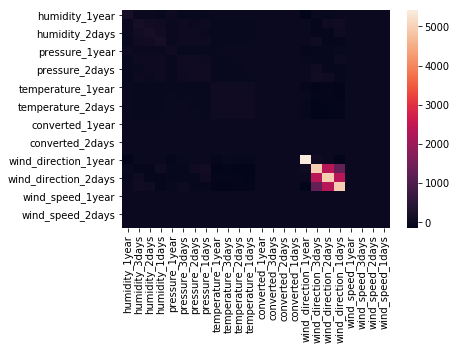

Correlation


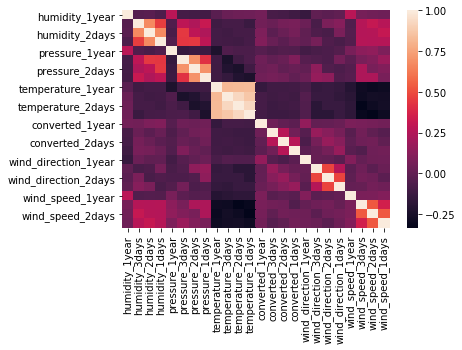

In [35]:
# Prints the explained variance of each feature in the given data
def print_pca(training_df):

    train_X = training_df.iloc[:, :-6]
    pca = PCA(n_components=24)
    pca.fit(train_X)
    print('Principle components:')
    print(pca.explained_variance_ratio_)
    # Dump components relations with features:
    indeces = list(training_df.iloc[:, :-6])
    df = pd.DataFrame(pca.components_,columns=training_df.iloc[:, :-6].columns,index = [i for i in range(0, 24)])
    print('\nCovariance:')
    plt.show(seaborn.heatmap(train_X.cov()))
    print('Correlation')
    plt.show(seaborn.heatmap(train_X.corr()))
    
print_pca(get_df_train_file('Boston'))

In [120]:
def save_all_models():
    all_cities = get_all_cities()
    
    if not os.path.exists(models_folder):
        os.makedirs(models_folder)
    
    #for city in all_cities:
    #print(city)
    all_cities = get_all_cities()
    for city in all_cities:
        print(city)
        all_models = create_all_attrib_models(city)

        city_folder = city + '/'

        if not os.path.exists(models_folder + city_folder):
            os.makedirs(models_folder + city_folder)

        for model in all_models:
            filename = models_folder + city_folder + model + '.pkl'

            pickle.dump(all_models[model], open(filename, 'wb+'))
save_all_models()

Vancouver
Portland
San Francisco
Seattle
Los Angeles
San Diego
Las Vegas
Phoenix
Albuquerque
Denver
San Antonio
Dallas
Houston
Kansas City
Minneapolis
Saint Louis
Chicago
Nashville
Indianapolis
Atlanta
Detroit
Jacksonville
Charlotte
Miami
Pittsburgh
Toronto
Philadelphia
New York
Montreal
Boston
Beersheba
Tel Aviv District
Eilat
Haifa
Nahariyya
Jerusalem


In [121]:
# Predict all attributes given a date (as string) and city,
# Returns: (prediction, true values)
def predict_all_attrib(city, date):
    
    city_folder = models_folder + city + '/'
    
    all_model_files = os.listdir(city_folder)
    all_models = []
    for model_file in all_model_files:
        filename = city_folder + model_file
        all_models.append( ( pickle.load(open(filename, 'rb')) , model_file.rstrip('.pkl') ) )
        
    
    test_df = get_df_test_file(city)
    
    # Get what row we want from the test file
    date = get_datetime(date)
    delta = date - get_datetime(test_date_range[0])
    row_index_from_date = delta.days
    
    test_X = test_df.loc[row_index_from_date][:-6].values.reshape(1, -1)
    
    predicted_attribs = []
    true_attribs = []
    
    for model, attrib in all_models:        
        predicted_attrib = model.predict(test_X)
        predicted_attribs.append((attrib, predicted_attrib))

        # Index into the global attrib array
        attrib_index = attribs.index(attrib)
        
        true_attrib = get_today_attrib(city, date, attrib_dfs[attrib_index])
        true_attribs.append((attrib, true_attrib))
        
    return [predicted_attribs, true_attribs]

In [124]:
# main - test creating df:

prediction = predict_all_attrib('Tel Aviv District', '2017-5-5')
print('Predicted:\n', prediction[0])
print()
print('True:\n', prediction[1])


Predicted:
 [('converted', array([2.59319714])), ('humidity', array([67.6075578])), ('pressure', array([1014.8957386])), ('temperature', array([294.19282534])), ('wind_direction', array([171.62296406])), ('wind_speed', array([2.6910629]))]

True:
 [('converted', 2.1666666666666665), ('humidity', 69.04166666666667), ('pressure', 1015.3333333333334), ('temperature', 293.48125), ('wind_direction', 183.33333333333334), ('wind_speed', 2.125)]


In [119]:

all_training_files = os.listdir(training_dir)
all_test_files = os.listdir(test_dir)
for training_file in all_training_files:
    df = pd.read_csv(training_dir + training_file)
    df = df.replace('', np.nan, regex=True)
    for column in df:
        df[column].fillna(df[column].mean(), inplace=True)
            
    
    df.to_csv(training_file, index=False)
        
for test_file in all_test_files:
    df = pd.read_csv(test_dir + test_file)
    df = df.replace('', np.nan, regex=True)
    for column in df:
        df[column].fillna(df[column].mean(), inplace=True)
    df.to_csv(test_file, index=False)